In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer


In [3]:
def showmetrics(pred):
    cm = confusion_matrix(dev_Y, pred)
    acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
    TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
    FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
    prec = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[1])
    f1 = 2*((prec*TPR)/(prec+TPR))

    print(cm)
    print("Model TPR: " + str(TPR))
    print("Model FPR: " + str(FPR))
    print("Model f1: " + str(f1))
    print("Model Precision: " + str(prec))
    print("Model Accuracy: " + str(acc))
    return TPR, FPR, f1, prec, acc

In [4]:
def ROC(n, model):
    TPRS = []
    FPRS = []
    
    for i in np.arange(n):
        
        model.class_weight = {0:1, 1:i}    
        model.fit(train_X, train_Y)
        pred = model.predict(dev_X)
        cm = confusion_matrix(dev_Y, pred)
        
        TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
        TPRS.append(TPR)

        FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
        FPRS.append(FPR)
    
    plt.plot(FPRS, TPRS)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Class Weight Tuning")
    return TPRS, FPRS

In [5]:
#Reading in data

data = pd.read_csv("Cleaning_Output_Log")
train_X, train_Y = pd.read_csv("train_X_CUT"), pd.read_csv("train_Y_CUT")["WF9_CESD7_CUT"]
dev_X, dev_Y = pd.read_csv("dev_X_CUT"), pd.read_csv("dev_Y_CUT")["WF9_CESD7_CUT"]

In [6]:
def scoring(y_true, y_pred, weight):
    cf = confusion_matrix(y_true, y_pred)
    fp = cf.ravel()[1]
    fn = cf.ravel()[2]
    return fn*weight+ fp
custom_scorer = make_scorer(scoring, weight = 250, greater_is_better = False)

## F1 Scoring

In [7]:
grid_values = {'max_features': np.linspace(1, len(train_X.columns), len(train_X.columns), dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88], 
              'class_weight' : [{0:0.14}]}
rf = RandomForestClassifier()
cv = KFold(n_splits=5,random_state=88,shuffle=True) 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='f1', cv=cv,verbose=1)
rf_cv.fit(train_X, train_Y)
rf_f1 = rf_cv.best_estimator_

#the optimal cross-validation accuracy and max_features
acc = rf_cv.cv_results_['mean_test_score']
max_features = rf_cv.cv_results_['param_max_features'].data
optimal_max_features = rf_cv.best_params_['max_features']
print("optimal max_features: ")
print(optimal_max_features)

Fitting 5 folds for each of 71 candidates, totalling 355 fits
optimal max_features: 
29


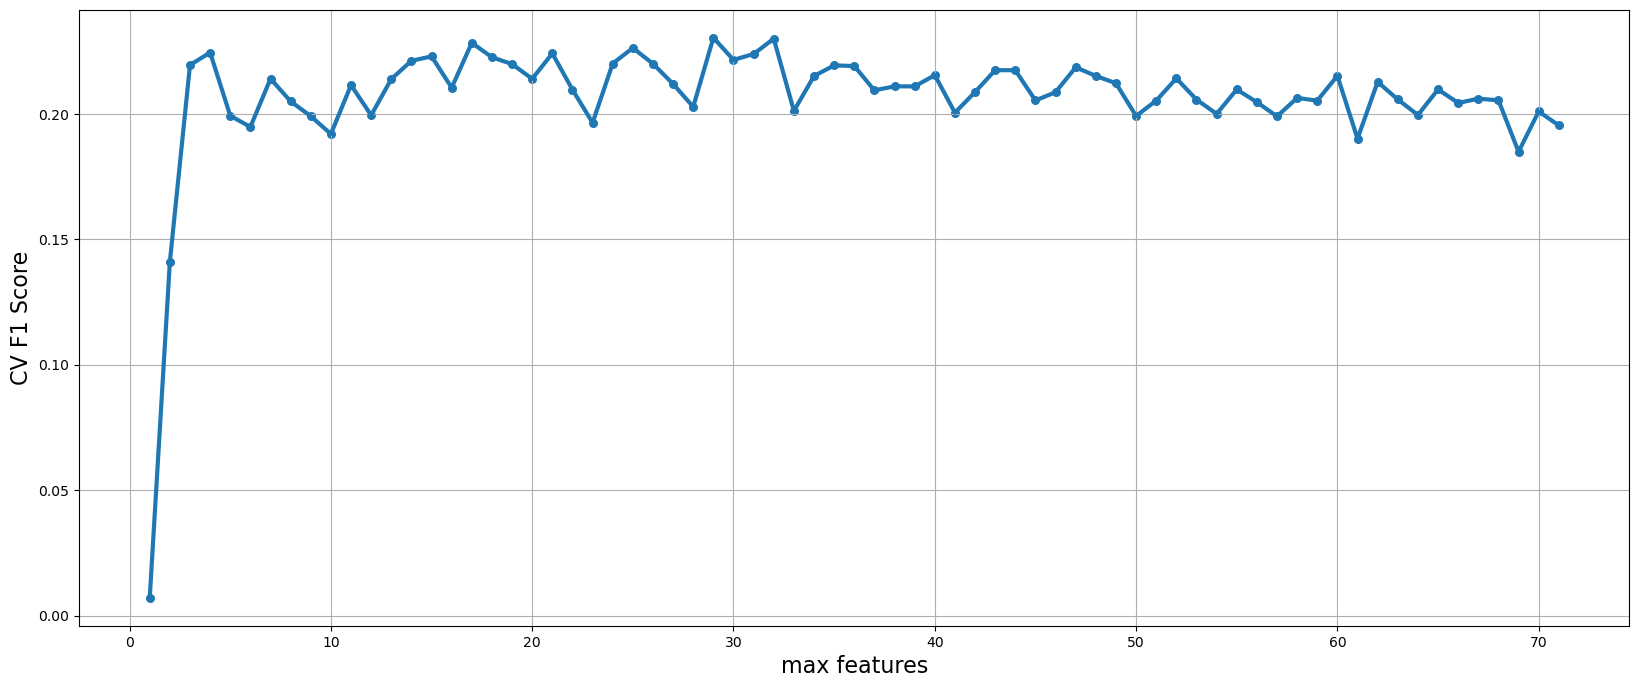

In [8]:
max_features = rf_cv.cv_results_['param_max_features'].data
accuracy_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(20, 8))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV F1 Score', fontsize=16)
plt.scatter(max_features, accuracy_scores, s=30)
plt.plot(max_features, accuracy_scores, linewidth=3)
plt.grid(True, which='both')

In [9]:
TPR_f1, FPR_f1, f1_f1, prec_f1, acc_f1 = showmetrics(rf_f1.predict(dev_X))

[[370   6]
 [ 32   9]]
Model TPR: 0.21951219512195122
Model FPR: 0.015957446808510637
Model f1: 0.32142857142857145
Model Precision: 0.6
Model Accuracy: 0.9088729016786571


#### Feature Importance

In [10]:
importances = rf_f1.feature_importances_
counter = 0
features = {}
for i in dev_X.columns:
    features[i] = importances[counter]
    counter += 1

In [11]:
index = []
column = ["Variable Importance"]
imp = []
for i in features:
    index.append(i)
    imp.append([features[i]])
importance = pd.DataFrame(imp,index = index, columns = column)
importance = importance.sort_values("Variable Importance", ascending = False).head(8)
importance

,Variable Importance
WF9_WORK_RESPECT,0.110384
WF9_WORK_BEHAVIOR,0.086285
WF9_ATTITUDES_PMS_PROG,0.078426
WF9_WORK_YRS,0.075569
WF9_CL6A_B_PRCNT_CHCLASS_BLACK,0.072221
WF9_WORK_HELP_AVAILABLE,0.055609
WF9_CAREER_EXPERIENCE,0.042399
WF9_WORK_MONTHS,0.038542


# Custom Scoring

In [12]:
grid_values = {'max_features': np.linspace(1, len(train_X.columns), len(train_X.columns), dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]}
rf = RandomForestClassifier()
cv = KFold(n_splits=5,random_state=88,shuffle=True) 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring=custom_scorer, cv=cv,verbose=1)
rf_cv.fit(train_X, train_Y)
rf_cs = rf_cv.best_estimator_

#the optimal cross-validation accuracy and max_features
acc = rf_cv.cv_results_['mean_test_score']
max_features = rf_cv.cv_results_['param_max_features'].data
optimal_max_features = rf_cv.best_params_['max_features']
print("optimal max_features: ")
print(optimal_max_features)

Fitting 5 folds for each of 71 candidates, totalling 355 fits
optimal max_features: 
37


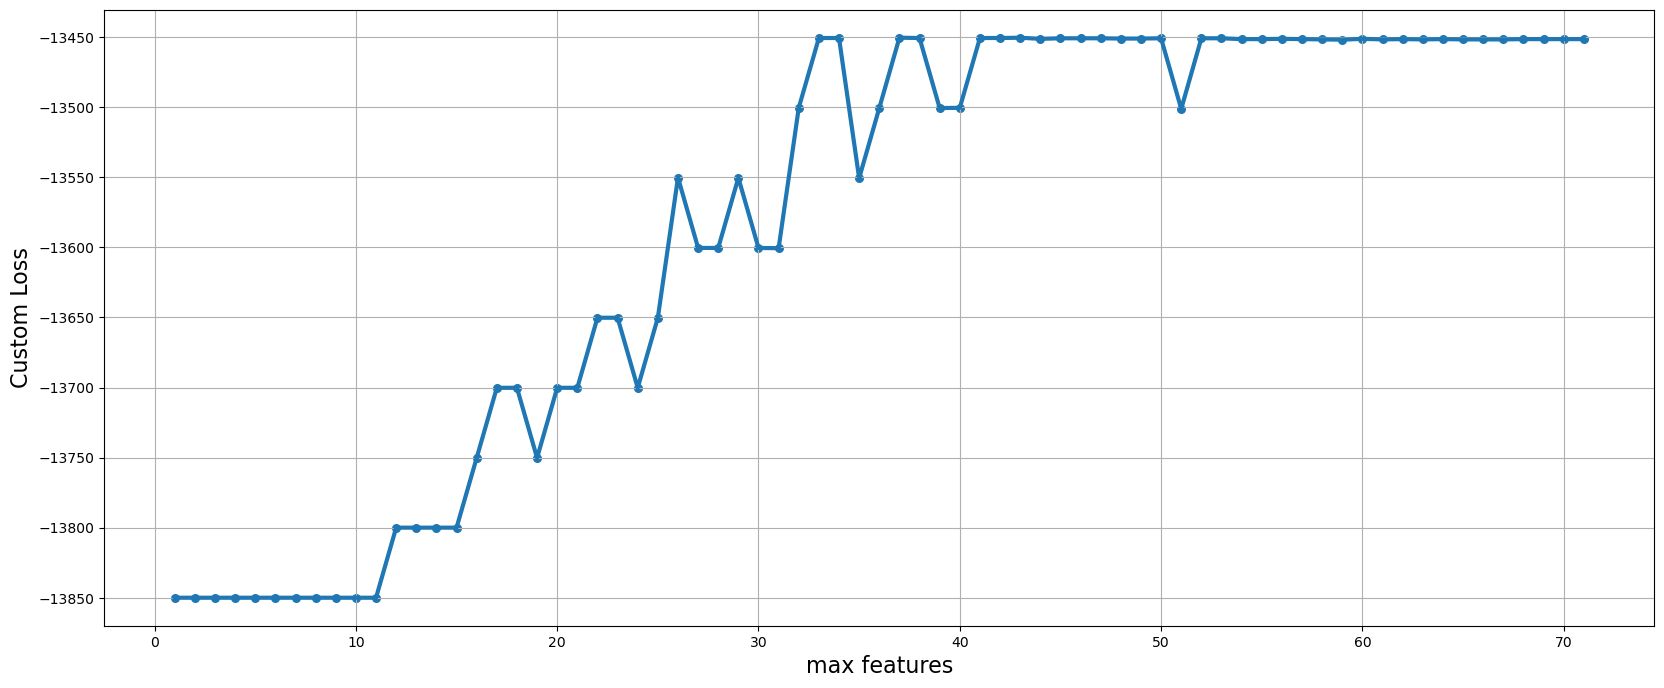

In [13]:
max_features = rf_cv.cv_results_['param_max_features'].data
accuracy_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(20, 8))
plt.xlabel('max features', fontsize=16)
plt.ylabel('Custom Loss', fontsize=16)
plt.scatter(max_features, accuracy_scores, s=30)
plt.plot(max_features, accuracy_scores, linewidth=3)
plt.grid(True, which='both')

In [14]:
TPR_cs, FPR_cs, f1_cs, prec_cs, acc_cs = showmetrics(rf_cs.predict(dev_X))

[[376   0]
 [ 41   0]]
Model TPR: 0.0
Model FPR: 0.0
Model f1: nan
Model Precision: nan
Model Accuracy: 0.9016786570743405


/tmp/ipykernel_81/3522597948.py:6: RuntimeWarning: invalid value encountered in long_scalars
  prec = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[1])


#### Feature Importance

In [30]:
importances = rf_cs.feature_importances_
counter = 0
features = {}
for i in dev_X.columns:
    features[i] = importances[counter]
    counter += 1

In [31]:
index = []
column = ["Variable Importance"]
imp = []
for i in features:
    index.append(i)
    imp.append([features[i]])
importance = pd.DataFrame(imp,index = index, columns = column)
importance = importance.sort_values("Variable Importance", ascending = False).head(8)
importance

,Variable Importance
WF9_WORK_RESPECT,0.097991
WF9_ATTITUDES_PMS_PROG,0.091807
WF9_WORK_YRS,0.077556
WF9_CL6A_B_PRCNT_CHCLASS_BLACK,0.074918
WF9_WORK_HELP_AVAILABLE,0.060038
WF9_WORK_BEHAVIOR,0.048828
WF9_CAREER_EXPERIENCE,0.044512
WF9_A19_HRS_SKILLS,0.043397


## Results Summary

In [32]:
index = ["F1","TPR", "FPR", "Precision", "Accuracy"]
columns = ["Custom Scoring CV, W = 250", "F1 CV, Class_weight = {0:0.15}"]
TPR = [TPR_cs, TPR_f1]
FPR = [FPR_cs, FPR_f1]
prec = [prec_cs, prec_f1]
acc = [acc_cs, acc_f1]
f1 = [f1_cs, f1_f1]
rows = [f1, TPR,FPR,prec,acc]

results = pd.DataFrame(rows, columns = columns, index = index)
results.to_csv("RandomForestResults.csv")

In [33]:
results

,"Custom Scoring CV, W = 250","F1 CV, Class_weight = {0:0.15}"
F1,NaN,0.296296
TPR,0.000000,0.195122
FPR,0.000000,0.013298
Precision,NaN,0.615385
Accuracy,0.901679,0.908873
